<a href="https://colab.research.google.com/github/sravanichinnu/Forecasting-energ-consumption-using-machine-learning/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly (1).csv


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import math
sns.set()
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df=pd.read_csv('AEP_hourly.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

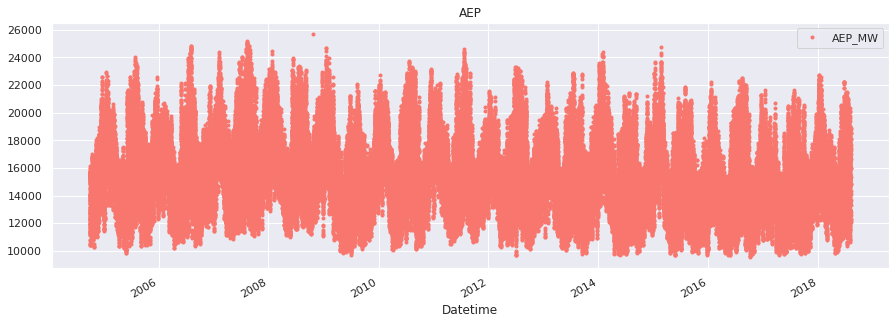

In [ ]:
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='AEP')

In [ ]:
split_date = '01-Jan-2016'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [ ]:
df_test.head()

,AEP_MW
Datetime,
2016-12-31 01:00:00,14877.0
2016-12-31 02:00:00,14588.0
2016-12-31 03:00:00,14514.0
2016-12-31 04:00:00,14591.0
2016-12-31 05:00:00,14604.0


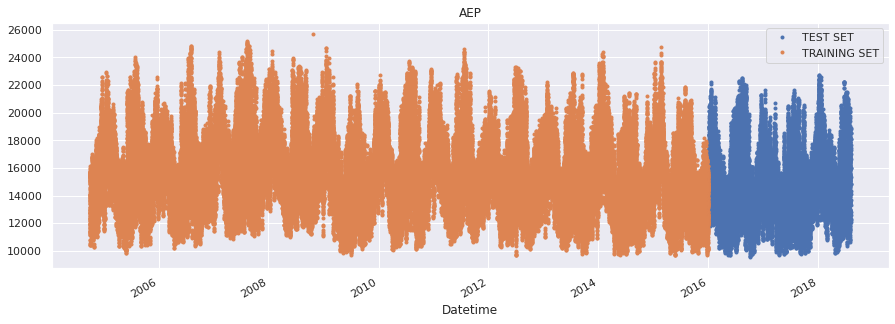

In [ ]:
_ = df_test.rename(columns = {'AEP_MW':'TEST SET'}).join(df_train.rename(columns={'AEP_MW':'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='AEP', style='.')

In [ ]:
#Create timeseries features
def create_features(df, label=None):
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear

  print(df.head())
  x = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth',
          'weekofyear']]
  if label:
    y = df[label]
    return x, y
  return x

In [ ]:
x_train, y_train = create_features(df_train, label='AEP_MW')
x_test, y_test = create_features(df_test, label='AEP_MW')

                      AEP_MW                date  hour  dayofweek  quarter  \
Datetime                                                                     
2004-12-31 01:00:00  13478.0 2004-12-31 01:00:00     1          4        4   
2004-12-31 02:00:00  12865.0 2004-12-31 02:00:00     2          4        4   
2004-12-31 03:00:00  12577.0 2004-12-31 03:00:00     3          4        4   
2004-12-31 04:00:00  12517.0 2004-12-31 04:00:00     4          4        4   
2004-12-31 05:00:00  12670.0 2004-12-31 05:00:00     5          4        4   

                     month  year  dayofyear  dayofmonth  weekofyear  
Datetime                                                             
2004-12-31 01:00:00     12  2004        366          31          53  
2004-12-31 02:00:00     12  2004        366          31          53  
2004-12-31 03:00:00     12  2004        366          31          53  
2004-12-31 04:00:00     12  2004        366          31          53  
2004-12-31 05:00:00     12  2004 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
x_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,5,4,4,12,2004,366,31,53
...,...,...,...,...,...,...,...,...
2015-01-01 20:00:00,20,3,1,1,2015,1,1,1
2015-01-01 21:00:00,21,3,1,1,2015,1,1,1
2015-01-01 22:00:00,22,3,1,1,2015,1,1,1


In [ ]:
y_train

Datetime
2004-12-31 01:00:00    13478.0
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
                        ...   
2015-01-01 20:00:00    16586.0
2015-01-01 21:00:00    16312.0
2015-01-01 22:00:00    15859.0
2015-01-01 23:00:00    15195.0
2015-01-02 00:00:00    14722.0
Name: AEP_MW, Length: 98594, dtype: float64

In [ ]:
zzz

In [ ]:
#Create XGBoost model
reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=300)
reg.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds = 50,
        verbose = True) #change verbose to True if you want to see it train

[0]	validation_0-rmse:14313.8	validation_1-rmse:13422.8
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:12910.3	validation_1-rmse:12016.9
[2]	validation_0-rmse:11650	validation_1-rmse:10755.6
[3]	validation_0-rmse:10518.8	validation_1-rmse:9623.81
[4]	validation_0-rmse:9503.57	validation_1-rmse:8607.45
[5]	validation_0-rmse:8593.67	validation_1-rmse:7698.72
[6]	validation_0-rmse:7778.09	validation_1-rmse:6916.82
[7]	validation_0-rmse:7048.68	validation_1-rmse:6193.2
[8]	validation_0-rmse:6390.48	validation_1-rmse:5540.5
[9]	validation_0-rmse:5807.59	validation_1-rmse:4985.03
[10]	validation_0-rmse:5278.25	validation_1-rmse:4464.86
[11]	validation_0-rmse:4812.6	validation_1-rmse:4041.63
[12]	validation_0-rmse:4400.87	validation_1-rmse:3676.17
[13]	validation_0-rmse:4025.98	validation_1-rmse:3318.2
[14]	validation_0-rmse:3697.68	validation_1-rmse:3009.45
[1

XGBRegressor(n_estimators=300, objective='reg:squarederror')

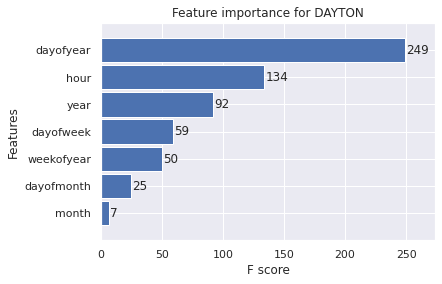

In [ ]:
#Feature importances
_ = plot_importance(reg, height = 0.9, title = "Feature importance for DAYTON")

In [ ]:
df_test.head()

,AEP_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2016-12-31 01:00:00,14877.0,2016-12-31 01:00:00,1,5,4,12,2016,366,31,52
2016-12-31 02:00:00,14588.0,2016-12-31 02:00:00,2,5,4,12,2016,366,31,52
2016-12-31 03:00:00,14514.0,2016-12-31 03:00:00,3,5,4,12,2016,366,31,52
2016-12-31 04:00:00,14591.0,2016-12-31 04:00:00,4,5,4,12,2016,366,31,52
2016-12-31 05:00:00,14604.0,2016-12-31 05:00:00,5,5,4,12,2016,366,31,52


In [ ]:
df_test['MW_prediction'] = reg.predict(x_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [ ]:
df_test.head()

,AEP_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_prediction
Datetime,,,,,,,,,,,
2016-12-31 01:00:00,14877.0,2016-12-31 01:00:00,1,5,4,12,2016,366,31,52,13948.712891
2016-12-31 02:00:00,14588.0,2016-12-31 02:00:00,2,5,4,12,2016,366,31,52,13663.438477
2016-12-31 03:00:00,14514.0,2016-12-31 03:00:00,3,5,4,12,2016,366,31,52,13663.438477
2016-12-31 04:00:00,14591.0,2016-12-31 04:00:00,4,5,4,12,2016,366,31,52,13663.438477
2016-12-31 05:00:00,14604.0,2016-12-31 05:00:00,5,5,4,12,2016,366,31,52,13663.438477


In [ ]:
df_all.head()

,AEP_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_prediction
Datetime,,,,,,,,,,,
2016-12-31 01:00:00,14877.0,2016-12-31 01:00:00,1,5,4,12,2016,366,31,52,13948.712891
2016-12-31 02:00:00,14588.0,2016-12-31 02:00:00,2,5,4,12,2016,366,31,52,13663.438477
2016-12-31 03:00:00,14514.0,2016-12-31 03:00:00,3,5,4,12,2016,366,31,52,13663.438477
2016-12-31 04:00:00,14591.0,2016-12-31 04:00:00,4,5,4,12,2016,366,31,52,13663.438477
2016-12-31 05:00:00,14604.0,2016-12-31 05:00:00,5,5,4,12,2016,366,31,52,13663.438477


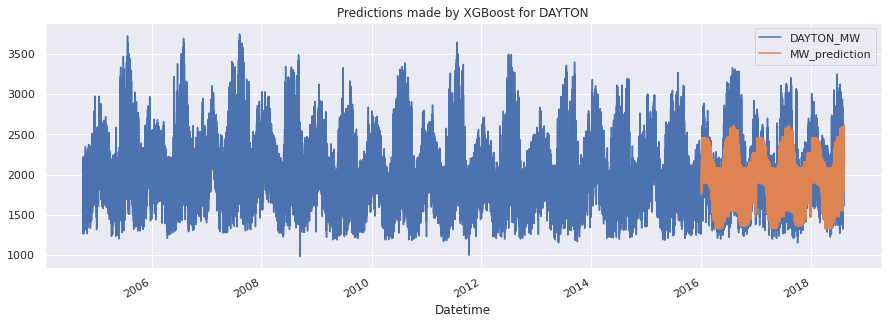

In [ ]:
_ = df_all[['DAYTON_MW', 'MW_prediction']].plot(figsize=(15,5),title = "Predictions made by XGBoost for DAYTON")

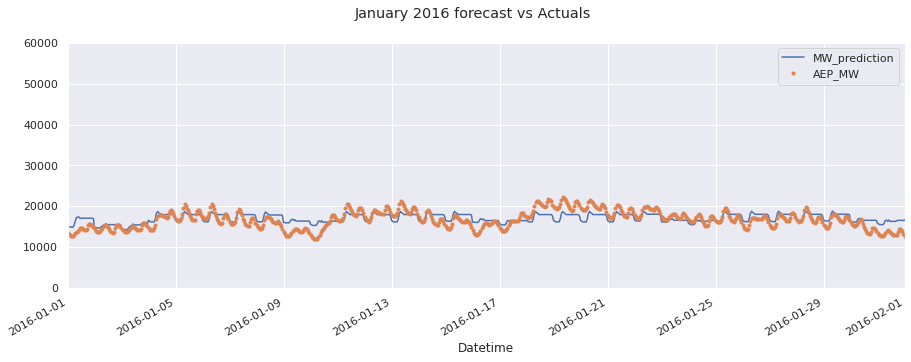

In [ ]:
#first month of predictions
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_prediction', 'AEP_MW']].plot(ax = ax, style=['-', '.'])
ax.set_xbound(lower = '01-01-2016', upper = '02-01-2016')
ax.set_ylim(0, 60000)
pltot = plt.suptitle('January 2016 forecast vs Actuals')

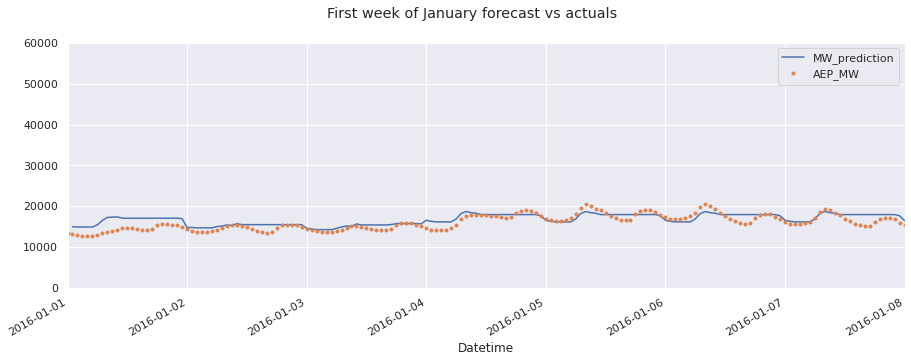

In [ ]:
#Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_prediction', 'AEP_MW']].plot(ax = ax, style=['-', '.'])
ax.set_xbound(lower = '01-01-2016', upper = '01-08-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First week of January forecast vs actuals')

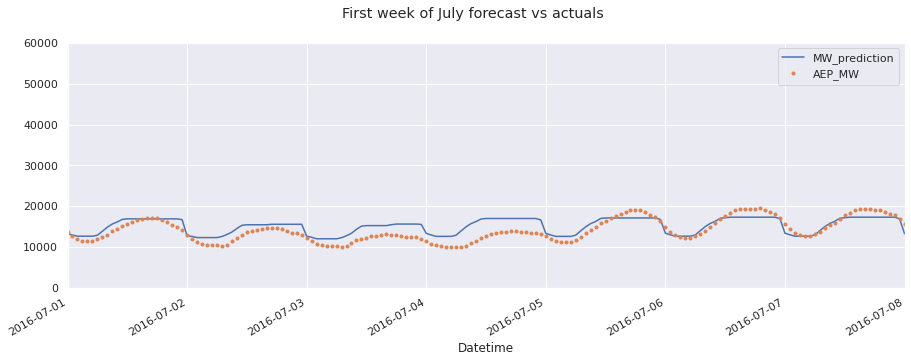

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_prediction', 'AEP_MW']].plot(ax = ax, style=['-', '.'])
ax.set_xbound(lower = '07-01-2016', upper = '07-08-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First week of July forecast vs actuals')

In [ ]:
#Error metrics on test set
mse = mean_squared_error(y_true = df_test['AEP_MW'],
                   y_pred = df_test['MW_prediction'])
print(mse)

2943209.338919892


In [ ]:
root_mean_squared_error = math.sqrt(mse)
print(root_mean_squared_error)

233.41250731082738


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_true = df_test['DAYTON_MW'],
                    y_pred = df_test['MW_prediction'])


0.6235253250110717

In [ ]:
mean_absolute_error(y_true = df_test['DAYTON_MW'],
                    y_pred = df_test['MW_prediction'])

179.70295883065006

In [ ]:
#Clalculating mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true = df_test['DAYTON_MW'],
                               y_pred = df_test['MW_prediction'])

8.833036458481324

In [ ]:
#Worst and best predicted days
df_test['error'] = df_test['AEP_MW'] - df_test['MW_prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year', 'month', 'dayofmonth']).mean()[['AEP_MW', 'MW_prediction', 'error', 'abs_error']]

In [ ]:
#over forecasted days
error_by_day.sort_values('error', ascending = True).head(10)

AEP_MW  MW_prediction        error    abs_error
year month dayofmonth                                                       
2017 1     2           13478.583333   17515.185547 -4036.602376  4036.602376
     2     24          13111.625000   17074.160156 -3962.535970  3962.535970
           19          12189.541667   16089.770508 -3900.228800  3900.228800
     1     22          12295.541667   16166.119141 -3870.577026  3870.577026
2018 2     20          13515.000000   17367.878906 -3852.878784  3852.878784
2017 2     12          12408.791667   16166.119141 -3757.327026  3757.327026
           23          13437.333333   17115.585938 -3678.251953  3678.251953
2016 2     20          12774.625000   16341.444336 -3566.819255  3566.819255
2018 2     21          13552.458333   17115.585938 -3563.126953  3563.126953
2017 2     7           14051.250000   17585.101562 -3533.851156  3533.851156

In [ ]:
#Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending = False).head(10)

AEP_MW  MW_prediction        error    abs_error
year month dayofmonth                                                       
2018 1     6           20847.833333   16202.430664  4645.402913  4645.402913
2016 12    16          19561.000000   15116.773438  4444.226929  4444.226929
2017 12    28          19396.291667   15170.783203  4225.508138  4225.508138
           31          18381.750000   14159.535156  4222.215332  4222.215332
2016 12    15          19246.625000   15170.783203  4075.841471  4075.841471
2017 1     2           13478.583333   17515.185547 -4036.602376  4036.602376
     2     24          13111.625000   17074.160156 -3962.535970  3962.535970
2018 1     7           19803.375000   15891.122070  3912.252726  3912.252726
2017 2     19          12189.541667   16089.770508 -3900.228800  3900.228800
     1     22          12295.541667   16166.119141 -3870.577026  3870.577026

In [ ]:
#Best predicted days
error_by_day.sort_values('abs_error', ascending = True).head(10)

AEP_MW  MW_prediction       error   abs_error
year month dayofmonth                                                     
2017 10    29          13135.416667   13173.700195  -38.283732  249.521281
2016 4     7           14262.041667   14235.071289   26.970174  251.966105
2017 3     19          13611.000000   13537.225586   73.774089  278.742025
2016 3     20          13420.250000   13537.225586 -116.975911  318.435465
2017 11    8           14602.750000   14516.124023   86.626383  327.914307
2016 3     3           17176.333333   16949.541016  226.791667  349.139974
2017 10    5           13987.625000   14223.660156 -236.035278  353.681763
     11    18          13509.958333   13660.392578 -150.434733  360.986491
2018 2     7           17425.625000   17585.101562 -159.476156  367.152262
     4     4           14338.500000   14235.071289  103.428507  375.597127

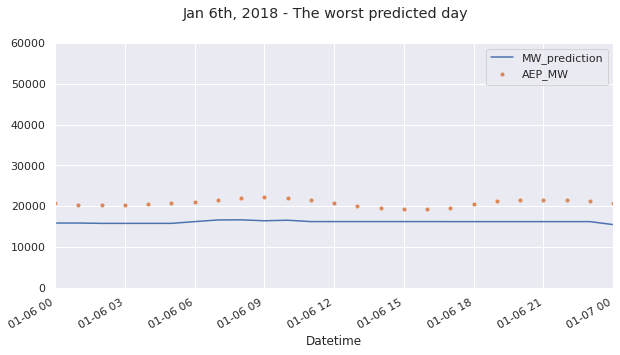

In [ ]:
#Plotting some best/worst predicted days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['MW_prediction', 'AEP_MW']].plot(ax = ax, style = ['-', '.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower = '01-06-2018', upper = '01-07-2018')
plot = plt.suptitle('Jan 6th, 2018 - The worst predicted day')

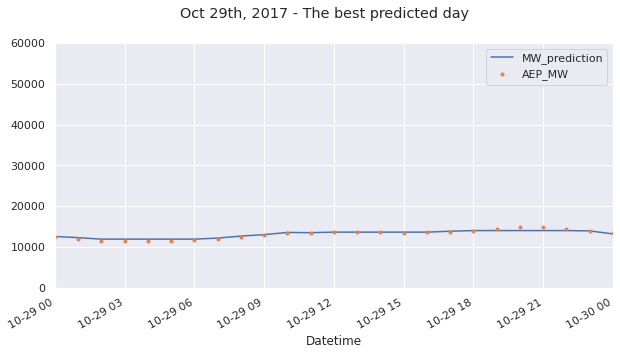

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['MW_prediction', 'AEP_MW']].plot(ax = ax, style = ['-', '.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower = '10-29-2017', upper = '10-30-2017')
plot = plt.suptitle('Oct 29th, 2017 - The best predicted day')